In [1]:
# 2023 Gabriel J. Diaz @ RIT

import os
import sys
import numpy as np

import logging
import pickle
from tqdm import tqdm

import io
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from pathlib import Path, PurePath

import sys
sys.path.append('../..')
from flow_source import *

logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [2]:
plt.rcParams['figure.figsize'] = [640/50., 480 /50.]

In [3]:
def crop_image(bgr_image,win_size):
    
    # crops off the bad OF estimation from the outer parts of the image
    h = np.shape(bgr_image)[0]
    w = np.shape(bgr_image)[1]

    # width of analysis window in proportions of image width/height

    b = int(h/2 + (win_size*h)/2)
    t = int(h/2 - (win_size*h)/2)
    l = int(w/2 - (win_size*w)/2)
    r = int(w/2 + (win_size*w)/2)

    sm_image = bgr_image[t:b,l:r,:]

    return sm_image


def plot_flow_overlay(image_in, flow_in, crop_to=0.8):

    image_in = crop_image(image_in,crop_to)
    flow_in = crop_image(flow_in,crop_to)
    
    xmax=np.shape(image_in)[1]
    xpoints = int(np.shape(image_in)[1])
    x=np.linspace(0,np.shape(image_in)[1],xmax)

    ymax=np.shape(image_in)[0]
    ypoints = int(np.shape(image_in)[0])
    y=np.linspace(0,np.shape(image_in)[0],ymax)

    x2d,y2d=np.meshgrid(x,y,indexing='xy')

    u = flow_in[...,0]
    v = flow_in[...,1]

    skippts=10
    skip=(slice(None,None,skippts),slice(None,None,skippts)) #don't plot all the point as this get too messy

    fig, ax = plt.subplots(figsize=(14,14))
    ax.axis('off') 
    plt.imshow(cv2.cvtColor(image_in, cv2.COLOR_BGR2RGB))
    plt.quiver(x2d[skip], y2d[skip],u[skip],v[skip],color='white', alpha=1, width=.005)
#     ,scale = 20000)
    

In [4]:
# a_file_path = Path(os.path.join('..','..','pupil_labs_data','GD-Short-Driving-Video'))
a_file_path = Path(os.path.join('..','..','pupil_labs_data','cb13'))
a_file_path
source = pupil_labs_source(a_file_path)


In [5]:
p = r'/Users/gjdpci/Documents/GitHub/retinal_flow_toolkit/cb13_world_nvidia2_hsv_overlay.mp4'
source.set_video_target(Path(p).as_uri())

True

In [6]:
video = cv2.VideoCapture(source.video_target_path)

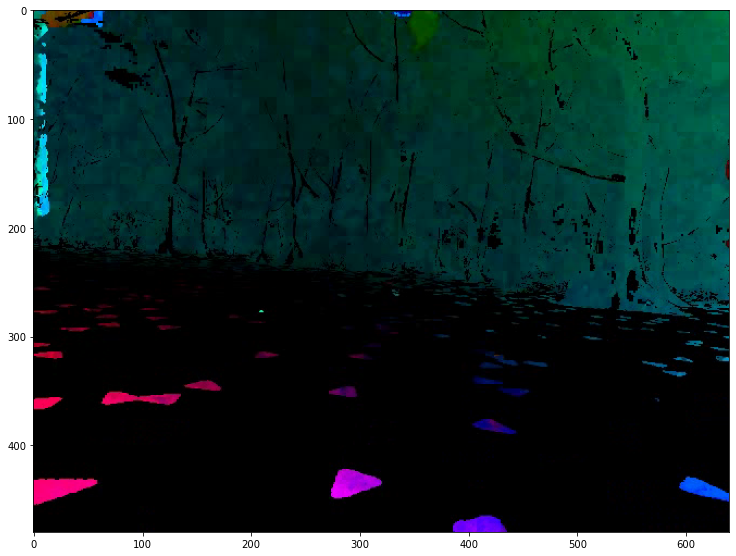

In [7]:
f = 23500

video.set(cv2.CAP_PROP_POS_FRAMES, f)
success, image = video.read()
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


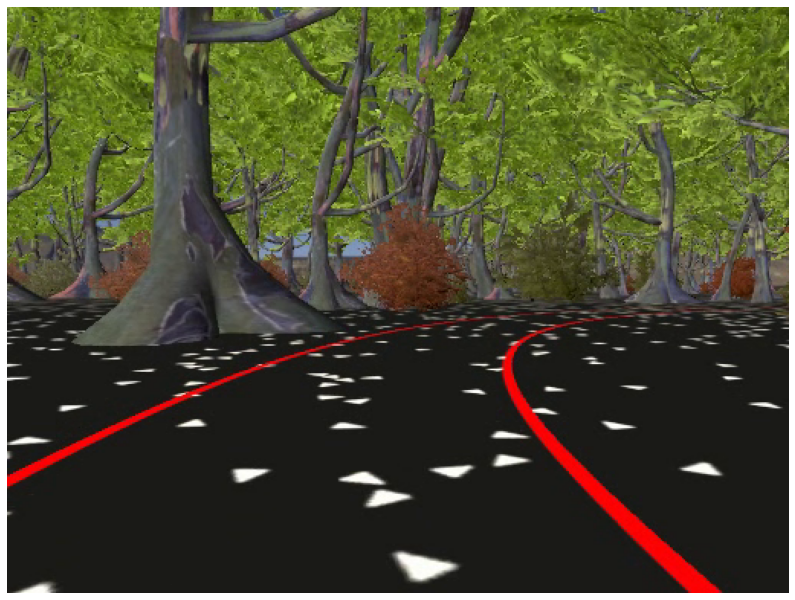

In [8]:
# f = 26000 # no flow
f = 27850

world_video = cv2.VideoCapture(source.world_video_path)
world_video.set(cv2.CAP_PROP_POS_FRAMES, f)
success, image = world_video.read()

fig, ax = plt.subplots(figsize=(14,14))
ax.axis('off') 
plt.imshow(crop_image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB),0.8))


In [9]:
hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

mag = hsv[...,2]
angle = (hsv[..., 0] * np.pi * 2.0) / 180.0 # angles are in radians here

u = mag * np.cos(angle) * mag * -1 # this is the same as flow[...,0] * mag * -1, as I did above
v = mag  * np.sin(angle) * mag

    

In [10]:
f = 27850
count = f
 
from collections import deque
video.set(cv2.CAP_PROP_POS_FRAMES, f)

buffer_len = 20

count = 0

flow_buffer = deque([] * buffer_len)

success = True
while success:
    
    success, image = video.read()
    
    if success:
        
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        mag = hsv[...,2]
#         mag = np.nan_to_num(np.log(mag))
#         mag = np.cbrt(mag)
        angle = (hsv[..., 0] * np.pi * 2.0) / 180.0 # angles are in radians here

        u = mag * np.cos(angle) * -1 # this is the same as flow[...,0] * mag * -1, as I did above
        v = mag  * np.sin(angle)
        
        flow = np.zeros([np.shape(image)[0],np.shape(image)[1],2])
        flow[...,0] = u
        flow[...,1] = v
        
        flow_buffer.appendleft(flow)
        
    count = count + 1
    if count > buffer_len:
        success = False

# print(count)

In [11]:
combined_flow = np.sum(flow_buffer,axis=0)
np.shape(combined_flow)

(480, 640, 2)

In [12]:
smoothed_flow = cv2.blur(combined_flow,[7,7])

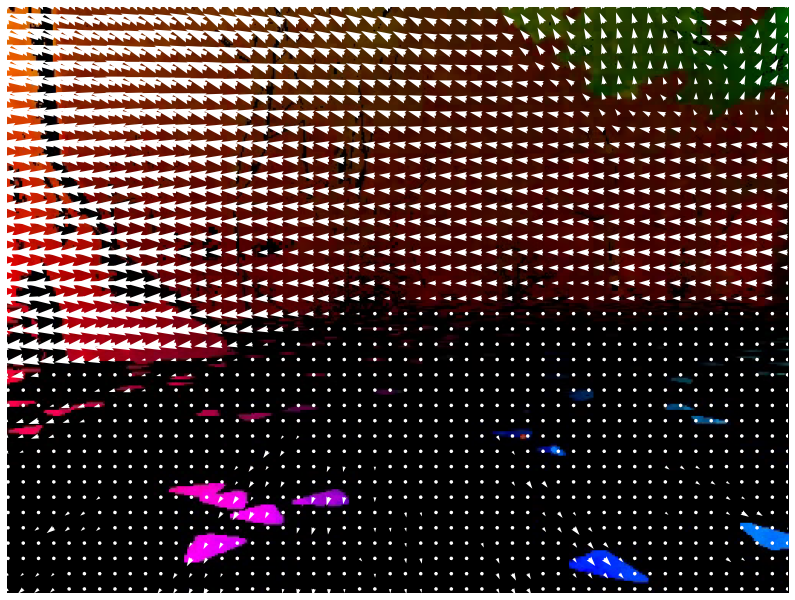

In [13]:
plot_flow_overlay(image,smoothed_flow, .8)

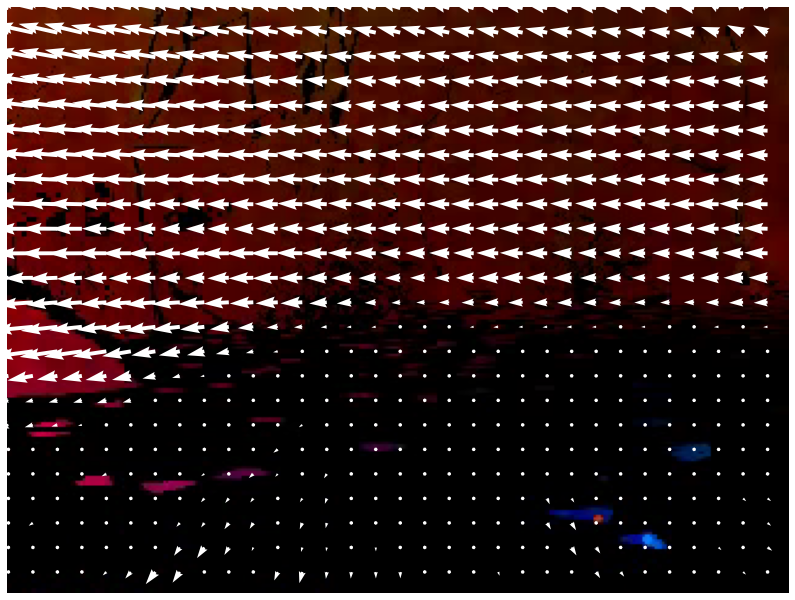

In [14]:
plot_flow_overlay(image,smoothed_flow, .5)

In [15]:
import scipy.signal as signal

u = smoothed_flow[...,0]
v = smoothed_flow[...,1]

xmax=np.shape(image)[1]
xpoints = int(np.shape(image)[1])
x=np.linspace(0,np.shape(image)[1],xmax)

ymax=np.shape(image)[0]
ypoints = int(np.shape(image)[0])
y=np.linspace(0,np.shape(image)[0],ymax)

#discrete numerical approximation to divergence and curl operator
#we express that divergence equals the flux out of a pixel
#this may not be the most elegant or accurate way
kerndx=np.array([[0,0,0],[1, 0, -1],[0,0,0]]) #strange sign convention?
kerndy=np.array([[0,1,0],[0, 0, 0],[0,-1,0]])

dx=(x[2]-x[0])
dy=(y[2]-y[0])

dudx=signal.convolve(u,kerndx,mode='same')/dx
dvdy=signal.convolve(v,kerndy,mode='same')/dy

div=dudx+dvdy

s2=np.sqrt(2.0)
dudy=signal.convolve(u,kerndy,mode='same')/dy
dvdx=signal.convolve(v,kerndx,mode='same')/dx
curlz=dvdx-dudy

# return div,curlz
# divergence,curlz=divcurl(u,v,x,y)

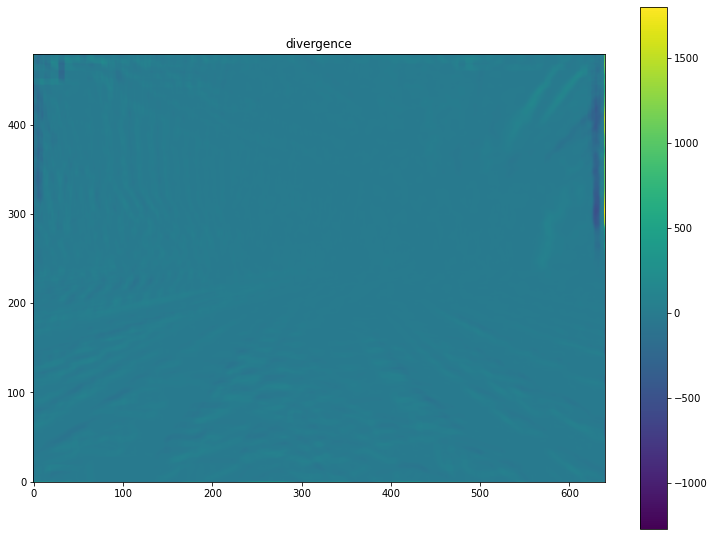

In [16]:
plt.imshow(np.flipud(div),origin='lower')
plt.title('divergence')
plt.colorbar()
plt.show()

In [17]:
def crop_div(div_image,win_size):
    
    # crops off the bad OF estimation from the outer parts of the image
    h = np.shape(div_image)[0]
    w = np.shape(div_image)[1]

    # width of analysis window in proportions of image width/height

    b = int(h/2 + (win_size*h)/2)
    t = int(h/2 - (win_size*h)/2)
    l = int(w/2 - (win_size*w)/2)
    r = int(w/2 + (win_size*w)/2)

    sm_image = div_image[t:b,l:r]

    return sm_image

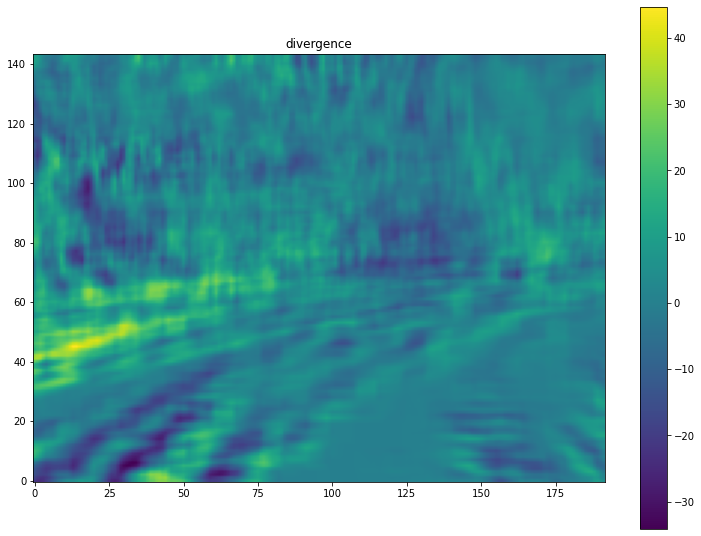

array([[-20.60418622, -23.09684334, -23.96950893, ...,   9.29254748,
          6.7753051 ,   4.54736518],
       [-17.59657347, -20.71613473, -22.08040651, ...,   7.09838478,
          4.14326106,   1.6792669 ],
       [-14.36091412, -17.0359167 , -18.11615181, ...,   8.27400323,
          4.54399125,   1.46141483],
       ...,
       [ 11.30348256,   9.26202955,   5.70804535, ...,   1.70269585,
          0.84006522,  -0.36560619],
       [ 10.29720455,   9.50704617,   5.75744985, ...,   1.92311628,
          1.39128315,   0.93701832],
       [  8.70224233,   9.08356127,   5.36294357, ...,   3.19214025,
          2.98835543,   2.82563214]])

In [18]:
sm_div = np.flipud(crop_div(div,0.3))

plt.imshow(sm_div,origin='lower')
plt.title('divergence')
plt.colorbar()
plt.show()

sm_div

In [19]:
div[int(np.shape(div)[0]/2), int(np.shape(div)[1]/2)]

7.768851183723942